## Project description

## Load Libraries

In [1]:
# ================================
# 0. Load Required Libraries
# ================================
library(rentrez)     # NCBI API
library(XML)         # Parse XML from NCBI
library(future)      # Parallel backend
library(furrr)       # Parallel map functions
library(Rsubread)
library(Seurat)
library(edgeR)
library(dplyr)
library(stringr)
library(topGO)
library(org.Sc.sgd.db)
library(ggplot2)
library(R.utils)
library(GO.db)
library(tidyr)
library(grid)
library(pheatmap)
library(RColorBrewer)
library(patchwork)
library(readxl)

Warning message:
“package ‘rentrez’ was built under R version 4.4.3”
Warning message:
“package ‘XML’ was built under R version 4.4.3”
Warning message:
“package ‘future’ was built under R version 4.4.3”
Warning message:
“package ‘furrr’ was built under R version 4.4.3”
Warning message:
“package ‘Rsubread’ was built under R version 4.4.3”
Warning message:
“package ‘Seurat’ was built under R version 4.4.3”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”
Loading required package: sp

Warning message:
“package ‘sp’ was built under R version 4.4.3”

Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Warning message:
“package ‘edgeR’ was built under R version 4.4.3”
Loading required package: limma

Warning message:
“package ‘limma’ was built under R version 4.4.3”
Warning message:
“package ‘dplyr’ was built under R version 4.4.3”

Attaching package: ‘dplyr’


The follow

In [2]:
plan(multisession, workers = 3)
cat("Using", 3, "workers for parallel processing.\n")

Warning message in checkNumberOfLocalWorkers(workers):
“Careful, you are setting up 3 localhost parallel workers with only 1 CPU cores available for this R process (per ‘fallback’), which could result in a 300% load. The soft limit is set to 100%. Overusing the CPUs has negative impact on the current R process, but also on all other processes of yours and others running on the same machine. See help("parallelly.maxWorkers.localhost", package = "parallelly") for further explanations and how to override the soft limit that triggered this warning”


Using 3 workers for parallel processing.


In [3]:
nbrOfWorkers()

[1] 3

## Fetch SRA IDs relevant to the Bioproject

In [5]:
# ================================
# 1. Get SRR IDs and stressed/unstressed conditions from BioProject
# ================================
bioproject_id <- "PRJNA397842"
search_res <- entrez_search(db = "sra", term = paste0(bioproject_id, "[BioProject]"), retmax = 500)
sra_ids <- search_res$ids

# Fetch SRA XML (as character string)
sra_xml_raw <- entrez_fetch(db = "sra", id = sra_ids, rettype = "xml", parsed = FALSE)

# Parse XML properly to avoid externalptr issue
sra_xml <- xmlParse(sra_xml_raw)

# Extract RUN nodes
runs <- getNodeSet(sra_xml, "//RUN")

# Extract SRR and Stress Status
srr_info <- lapply(runs, function(run) {
  srr <- xmlGetAttr(run, "accession")
  
  # Handle nested structure
  pool <- getNodeSet(run, ".//Pool/Member")[[1]]
  sample_title <- xmlGetAttr(pool, "sample_title")

  stress_status <- if (grepl("Unstressed", sample_title, ignore.case = TRUE)) {
    "Unstressed"
  } else if (grepl("Stressed", sample_title, ignore.case = TRUE)) {
    "Stressed"
  } else {
    "Unknown"
  }

  return(data.frame(
    SRR = srr,
    Title = sample_title,
    Condition = stress_status,
    stringsAsFactors = FALSE
  ))
})

In [6]:
# View dataframe
srr_df <- do.call(rbind, srr_info)
head(srr_df)

,SRR,Title,Condition
,<chr>,<chr>,<chr>
1,SRR5924358,BY4741_Unstressed_1784042189_BY94,Unstressed
2,SRR5924357,BY4741_Unstressed_1784042189_BY93,Unstressed
3,SRR5924356,BY4741_Unstressed_1784042189_BY92,Unstressed
4,SRR5924355,BY4741_Unstressed_1784042189_BY91,Unstressed
5,SRR5924354,BY4741_Unstressed_1784042189_BY90,Unstressed
6,SRR5924353,BY4741_Unstressed_1784042189_BY9,Unstressed


## Download files using SRA IDs

In [7]:
download_one_srr <- function(srr, output_dir = "Fastq_files", log_dir = "logs") {
  dir.create(output_dir, showWarnings = FALSE, recursive = TRUE)

  # SKIP if both paired files already exist
  fq1 <- file.path(output_dir, paste0(srr, "_1.fastq.gz"))
  fq2 <- file.path(output_dir, paste0(srr, "_2.fastq.gz"))
  if (file.exists(fq1) && file.exists(fq2)) {
    message("Skipping ", srr, " (already downloaded)")
    return(srr)
  }

  message("Downloading ", srr)

  # Download SRA
  prefetch_cmd <- sprintf("prefetch --output-directory %s %s", output_dir, srr)
  prefetch_status <- system(prefetch_cmd)

  if (prefetch_status != 0) {
    message("Prefetch failed for ", srr)
    return(NA)
  }

  message("Converting ", srr)

  # Convert to FASTQ
  sra_path <- file.path(output_dir, srr, paste0(srr, ".sra"))
  fasterq_cmd <- sprintf("fasterq-dump \"%s\" --split-files -O \"%s\"", sra_path, output_dir)
  fasterq_status <- system(fasterq_cmd)

  if (fasterq_status != 0) {
    message("fasterq-dump failed for ", srr)
    return(NA)
  }

  # Gzip
  fqs <- list.files(output_dir, pattern = paste0("^", srr, "_[12]\\.fastq$"), full.names = TRUE)
  if (length(fqs)) {
    invisible(lapply(fqs, function(fq) {
      system(paste("gzip", shQuote(fq)))
    }))
  }

  file.remove(sra_path)

  message("Done: ", srr)
  return(srr)
}

In [ ]:
# ================================
# 3. Run Download in Parallel
# ================================
results <- future_map(srr_list, ~download_one_srr(.x), .progress = TRUE)
cat("All jobs done.\n")

## Index Reference Genome & perform Alignment

In [16]:
# ================================
# 4. Index Reference Genome
# ================================

# COMMENTING BECAUSE ALREADY HAVE DOWNLOADED FILES

# #Downloading Reference Genome file (downloaded from emsembl browser: FASTA file)
# url<-"ftp://ftp.ensembl.org/pub/release-96/fasta/saccharomyces_cerevisiae/dna/Saccharomyces_cerevisiae.R64-1-1.dna_sm.toplevel.fa.gz"
# destination<-"temp/Saccharomyces_cerevisiae.R64-1-1.dna_sm.toplevel.fa.gz"
# download.file(url,destination)
# gunzip(destination)

# #Downloading GTF (Annotation file for FASTA file) file
# url<-"ftp://ftp.ensembl.org/pub/release-96/gtf/saccharomyces_cerevisiae/Saccharomyces_cerevisiae.R64-1-1.96.gtf.gz"
# destination<-"temp/Saccharomyces_cerevisiae.R64-1-1.96.gtf.gz"
# download.file(url,destination)
# gunzip(destination)

# Downloading reference genome and annotation file
ref_fasta <- "/gladstone/corces/lab/users/mchidrawar/temp_proj/temp/Saccharomyces_cerevisiae.R64-1-1.dna_sm.toplevel.fa"
gtf_file <- "/gladstone/corces/lab/users/mchidrawar/temp_proj/temp/Saccharomyces_cerevisiae.R64-1-1.96.gtf"
index_path <- "temp/Sc_full_index_rsubread"
if (!file.exists(paste0(index_path, ".00.b.array"))) {
  buildindex(basename = index_path, reference = ref_fasta)
}

In [14]:
# ================================
# 5. Align & Generate BAM (Parallel)
# ================================
align_one_sample <- function(srr, output_dir = "Fastq_files", bam_dir = "BAM") {
  dir.create(bam_dir, showWarnings = FALSE, recursive = TRUE)
  fq1 <- file.path(output_dir, paste0(srr, "_1.fastq.gz"))
  fq2 <- file.path(output_dir, paste0(srr, "_2.fastq.gz"))
  bam_out <- file.path(bam_dir, paste0(srr, ".BAM"))
  
  # Skip if BAM already exists
  if (file.exists(bam_out)) {
    message("Skipping ", srr, " (BAM already exists)")
    return(bam_out)
  }
    
  align(index = index_path, readfile1 = fq1, readfile2 = fq2,
        output_file = bam_out, nthreads = 4)
  return(bam_out)
}

In [15]:
bam_files <- future_map(srr_list, ~align_one_sample(.x), .progress = TRUE, seed = TRUE)

Warning message:
“package ‘future’ was built under R version 4.4.3”
Warning message:
“package ‘purrr’ was built under R version 4.4.3”
Warning message:
“package ‘Rsubread’ was built under R version 4.4.3”
✅ Skipping SRR5924358 (BAM already exists)

✅ Skipping SRR5924357 (BAM already exists)

✅ Skipping SRR5924356 (BAM already exists)

✅ Skipping SRR5924355 (BAM already exists)

✅ Skipping SRR5924354 (BAM already exists)

✅ Skipping SRR5924353 (BAM already exists)

✅ Skipping SRR5924352 (BAM already exists)

✅ Skipping SRR5924351 (BAM already exists)

✅ Skipping SRR5924350 (BAM already exists)

✅ Skipping SRR5924349 (BAM already exists)

✅ Skipping SRR5924348 (BAM already exists)

✅ Skipping SRR5924347 (BAM already exists)

✅ Skipping SRR5924346 (BAM already exists)

✅ Skipping SRR5924345 (BAM already exists)

✅ Skipping SRR5924344 (BAM already exists)

✅ Skipping SRR5924343 (BAM already exists)

✅ Skipping SRR5924342 (BAM already exists)

✅ Skipping SRR5924341 (BAM already exists)

✅ S

## FeatureCounts (Gene Expression Counts Matrix)

In [2]:
# ================================
# 6. FeatureCounts (Final Count Matrix)
# ================================
fc_out <- "gene_counts.txt"
if (!file.exists(fc_out)){
    fc <- featureCounts(files = unlist(bam_files), annot.ext = gtf_file, isGTFAnnotationFile = TRUE,
                        GTF.featureType = "exon", GTF.attrType = "gene_id", useMetaFeatures = TRUE,
                        isPairedEnd = TRUE, nthreads = 4)

    write.table(fc$counts, file = fc_out, sep = "\t", quote = FALSE)
} else {
    message("Skipping, Counts Matrix already exists")
}

✅ Skipping, Counts Matrix already exists



## Preliminary Analysis

In [3]:
# ================================
# 7. Load Counts in Seurat
# ================================
counts <- read.table(fc_out, header = TRUE, row.names = 1)
colnames(counts) <- gsub(".BAM", "", basename(colnames(counts)))
so <- CreateSeuratObject(counts = counts, project = "YeastSaltStress", min.cells = 3, min.features = 200)

Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


In [7]:
# ================================
# 8. Add Metadata and Normalize
# ================================

# Map conditions from srr_df based on SRR IDs matching colnames of counts/Seurat object

so$Condition <- srr_df$Condition[match(colnames(so), srr_df$SRR)]

# Check if any SRR IDs didn’t find a match in srr_df
if(any(is.na(so$Condition))) {
  warning("Some SRR IDs in Seurat object don't have metadata conditions!")
  print(colnames(so)[is.na(so$Condition)])
  # assign a default value if missing:
  so$Condition[is.na(so$Condition)] <- "Unknown"
}

# Normalize and scale
so <- NormalizeData(so)
so <- FindVariableFeatures(so)
so <- ScaleData(so)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



PC_ 1 
Positive:  YML123C, YLR249W, YPL019C, YHR215W, YMR229C, YLR180W, YMR217W, YAR071W, YGL148W, YGL008C 
	   YJL012C, YDR496C, YLR413W, YER056C, YMR307W, YLR214W, YBR078W, YDR060W, YML056C, YGR103W 
	   YDL055C, YGR285C, YOR341W, YPR010C, YLR106C, YEL046C, YPR112C, YHR208W, YJL130C, YPL012W 
Negative:  YHR087W, YFL014W, YML128C, YDL022W, YMR169C, YDR074W, YER062C, YMR105C, YBR126C, YCL040W 
	   YOR374W, YML100W, YHR096C, YOL151W, YBR117C, YGL037C, YGR088W, YDL222C, YOR161C, YDL223C 
	   YHR033W, YGR086C, YDR040C, YGR052W, YER150W, YKL035W, YHL021C, YOL084W, YDR536W, YAL061W 
PC_ 2 
Positive:  YNL160W, YPR149W, YDR376W, YOR186W, YDR033W, YDR070C, YDR150W, YER150W, YFL003C, YOL085C 
	   YPL046C, YHL028W, YEL064C, YOR383C, YGR066C, YHL014C, YOR060C, YFR029W, YBR092C, YDR246W-A 
	   YKL218C, YMR094W, YBR148W, YJL052W, YMR279C, YKL178C, YDL033C, YMR025W, YNL054W, YML064C 
Negative:  YDL003W, YGR189C, YNL300W, YPL256C, YOL007C, YER070W, YMR305C, YPL163C, YNL102W, YJL012C 
	   YPL153C, YLR

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 163
Number of edges: 5019

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6063
Number of communities: 3
Elapsed time: 0 seconds


20:19:51 UMAP embedding parameters a = 0.9922 b = 1.112

20:19:51 Read 163 rows and found 10 numeric columns

20:19:51 Using Annoy for neighbor search, n_neighbors = 30

20:19:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:19:52 Writing NN index file to temp file /scratch/mchidrawar/RtmpW2t37y/file4cb5c77dabde1

20:19:52 Searching Annoy index using 1 thread, search_k = 3000

20:19:52 Annoy recall = 100%

20:19:53 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:19:54 Initializing from normalized Laplacian + noise (using RSpectra)

20:19:54 Commencing optimization for 500 epochs, with 5862 positive edges

20:19:54 Using rng type: pcg

20:19:55 Optimization finished

20:19:55 UMAP embedding parameters a = 0.9922 b = 1.112

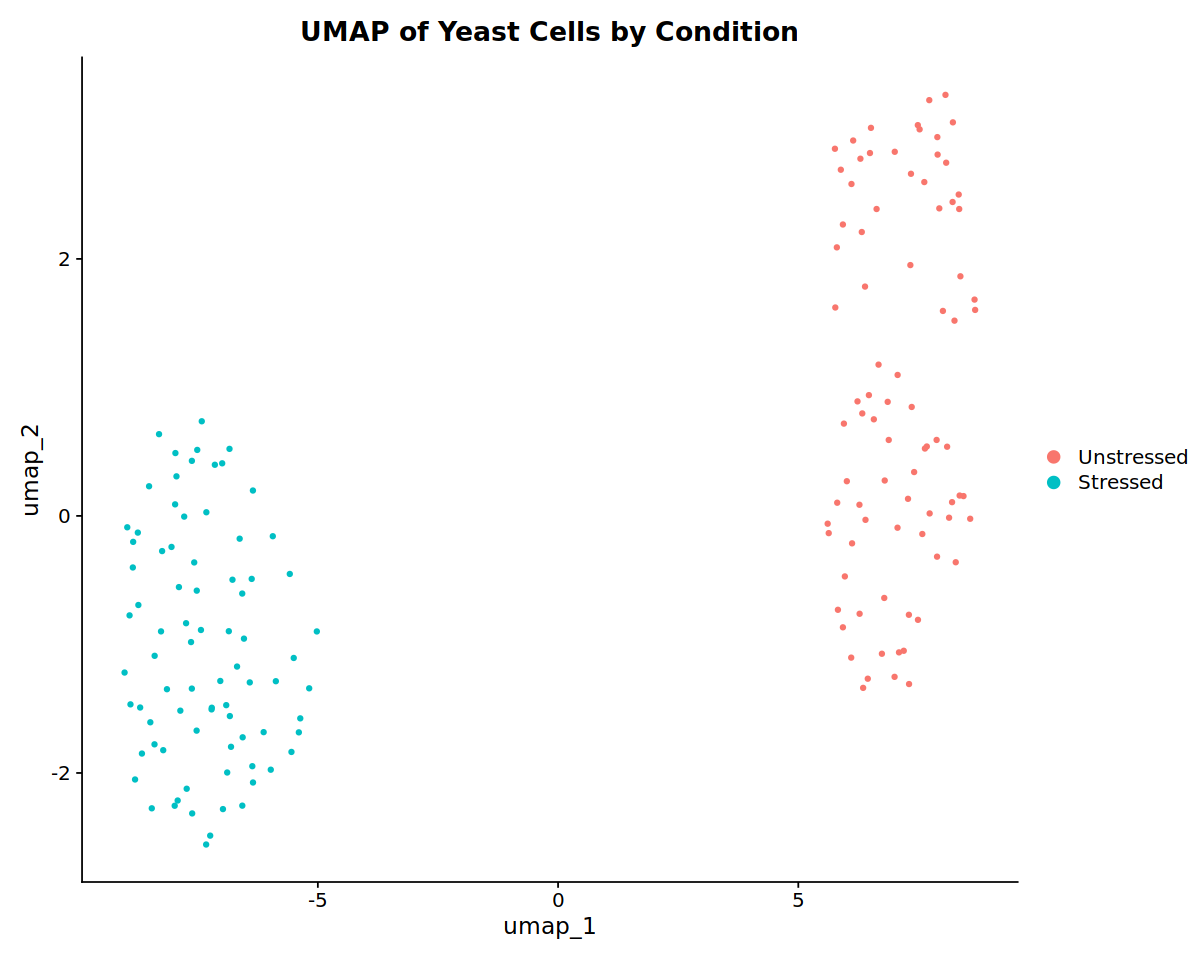

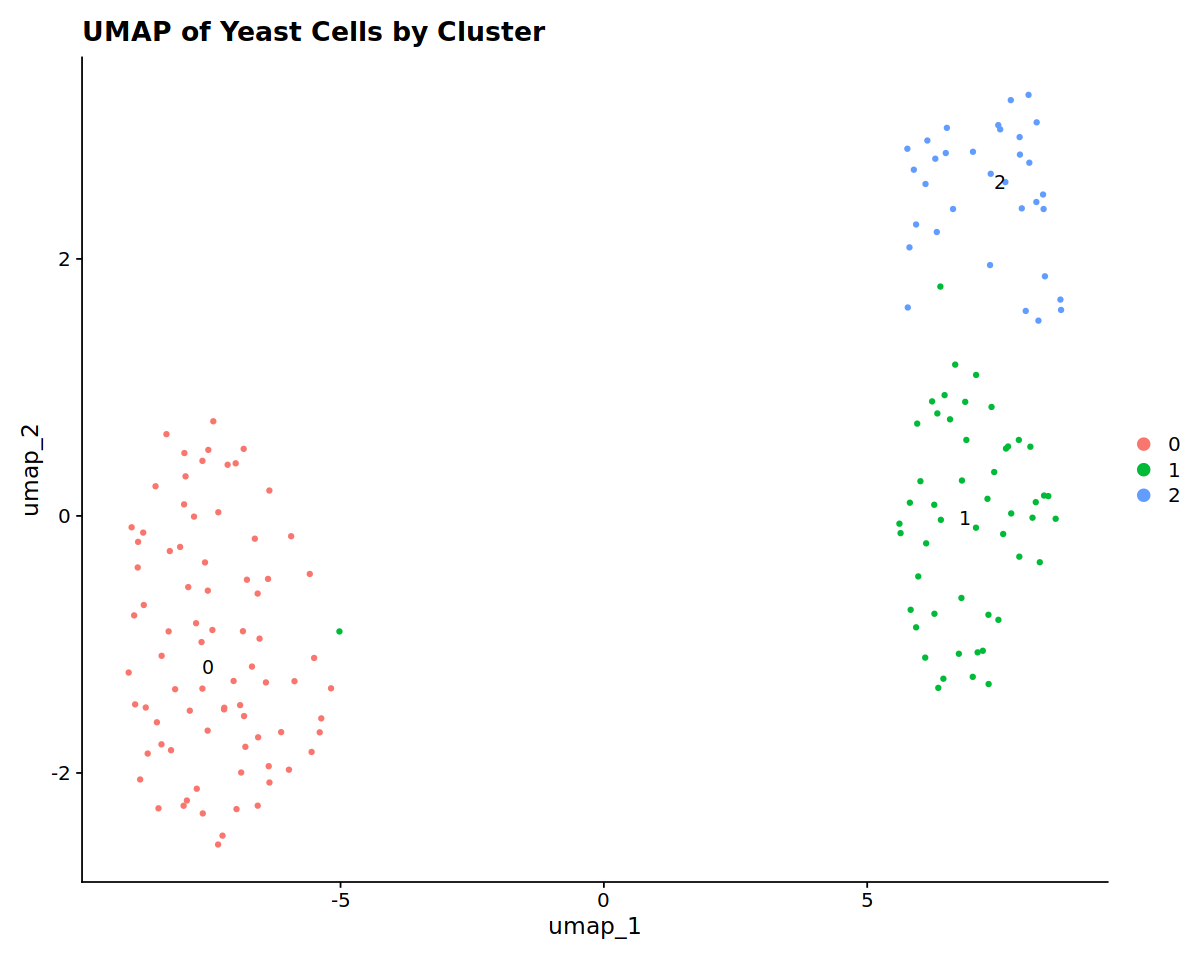

In [99]:
# ================================
# 9. PCA and Clustering
# ================================
so <- RunPCA(so, features = VariableFeatures(so))
so <- FindNeighbors(so, dims = 1:10)
so <- FindClusters(so)
so <- RunUMAP(so, dims = 1:10)

set.seed(1234)
so <- RunUMAP(so, dims = 1:10)

options(repr.plot.width = 10, repr.plot.height = 8)

# UMAP colored by Condition (Stressed vs Unstressed)
DimPlot(so, reduction = "umap", group.by = "Condition") + 
  ggtitle("UMAP of Yeast Cells by Condition")

# UMAP colored by Clusters with labels
DimPlot(so, reduction = "umap", label = TRUE) + 
  ggtitle("UMAP of Yeast Cells by Cluster")

In [84]:
# ================================
# 10. Differential Expression (DE) between Conditions
# ================================
# Condition is a factor with levels
so$Condition <- factor(so$Condition, levels = c("Unstressed", "Stressed"))

# Find markers DE between Stressed and Unstressed
de_markers <- FindMarkers(so, ident.1 = "Stressed", ident.2 = "Unstressed", group.by = "Condition")

# Save DE table
write.csv(de_markers, "DE_Stressed_vs_Unstressed.csv")

# Top 10 DE genes by adjusted p-value (or logFC)
top_genes <- rownames(de_markers)[order(de_markers$p_val_adj)][1:10]

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



In [85]:
# ================================
# 11a. GO Enrichment using topGO
# ================================
# Extract genes
all_genes <- rownames(so)

# Binary vector: 1 if DE gene (adjusted p < 0.05), else 0
geneList <- ifelse(all_genes %in% rownames(de_markers[de_markers$p_val_adj < 0.05, ]), 1, 0)
names(geneList) <- all_genes

# Map ORFs to GO terms directly
orf_keys <- keys(org.Sc.sgd.db, keytype = "ORF")
geneID2GO_raw <- mapIds(org.Sc.sgd.db,
                        keys = orf_keys,
                        column = "GO",
                        keytype = "ORF",
                        multiVals = "list")

# Filter to Biological Process (BP) GO terms
geneID2GO_BP <- lapply(geneID2GO_raw, function(go_ids) {
  bp_ids <- go_ids[Ontology(go_ids) == "BP"]
  return(bp_ids)
})
geneID2GO_BP <- geneID2GO_BP[lengths(geneID2GO_BP) > 0]

# matching gene IDs with Seurat object for validation
length(intersect(names(geneID2GO_BP), names(geneList)))

# Create topGO object
GOdata <- new("topGOdata",
              ontology = "BP",
              allGenes = geneList,
              geneSelectionFun = function(x) x == 1,
              annot = annFUN.gene2GO,
              gene2GO = geneID2GO_BP,
              nodeSize = 5)

# Run enrichment test
resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")

# Extract top GO terms
allRes <- GenTable(GOdata, classicFisher = resultFisher,
                   orderBy = "classicFisher", topNodes = 10)

print(allRes)

'select()' returned 1:many mapping between keys and columns



[1] 6405


Building most specific GOs .....

	( 2913 GO terms found. )


Build GO DAG topology ..........

	( 4665 GO terms and 10203 relations. )


Annotating nodes ...............

	( 5962 genes annotated to the GO terms. )


			 -- Classic Algorithm -- 

		 the algorithm is scoring 1839 nontrivial nodes
		 parameters: 
			 test statistic: fisher



        GO.ID                                 Term Annotated Significant
1  GO:0002181              cytoplasmic translation       174         129
2  GO:0042254                  ribosome biogenesis       467         205
3  GO:0022613 ribonucleoprotein complex biogenesis       557         218
4  GO:0006364                      rRNA processing       356         151
5  GO:0016072               rRNA metabolic process       415         162
6  GO:0042273   ribosomal large subunit biogenesis       131          83
7  GO:0042274   ribosomal small subunit biogenesis       143          86
8  GO:0043043         peptide biosynthetic process       517         180
9  GO:0006412                          translation       513         178
10 GO:0043604           amide biosynthetic process       559         187
   Expected classicFisher
1     24.17        <1e-30
2     64.86        <1e-30
3     77.36        <1e-30
4     49.44        <1e-30
5     57.64        <1e-30
6     18.19        <1e-30
7     19.86    

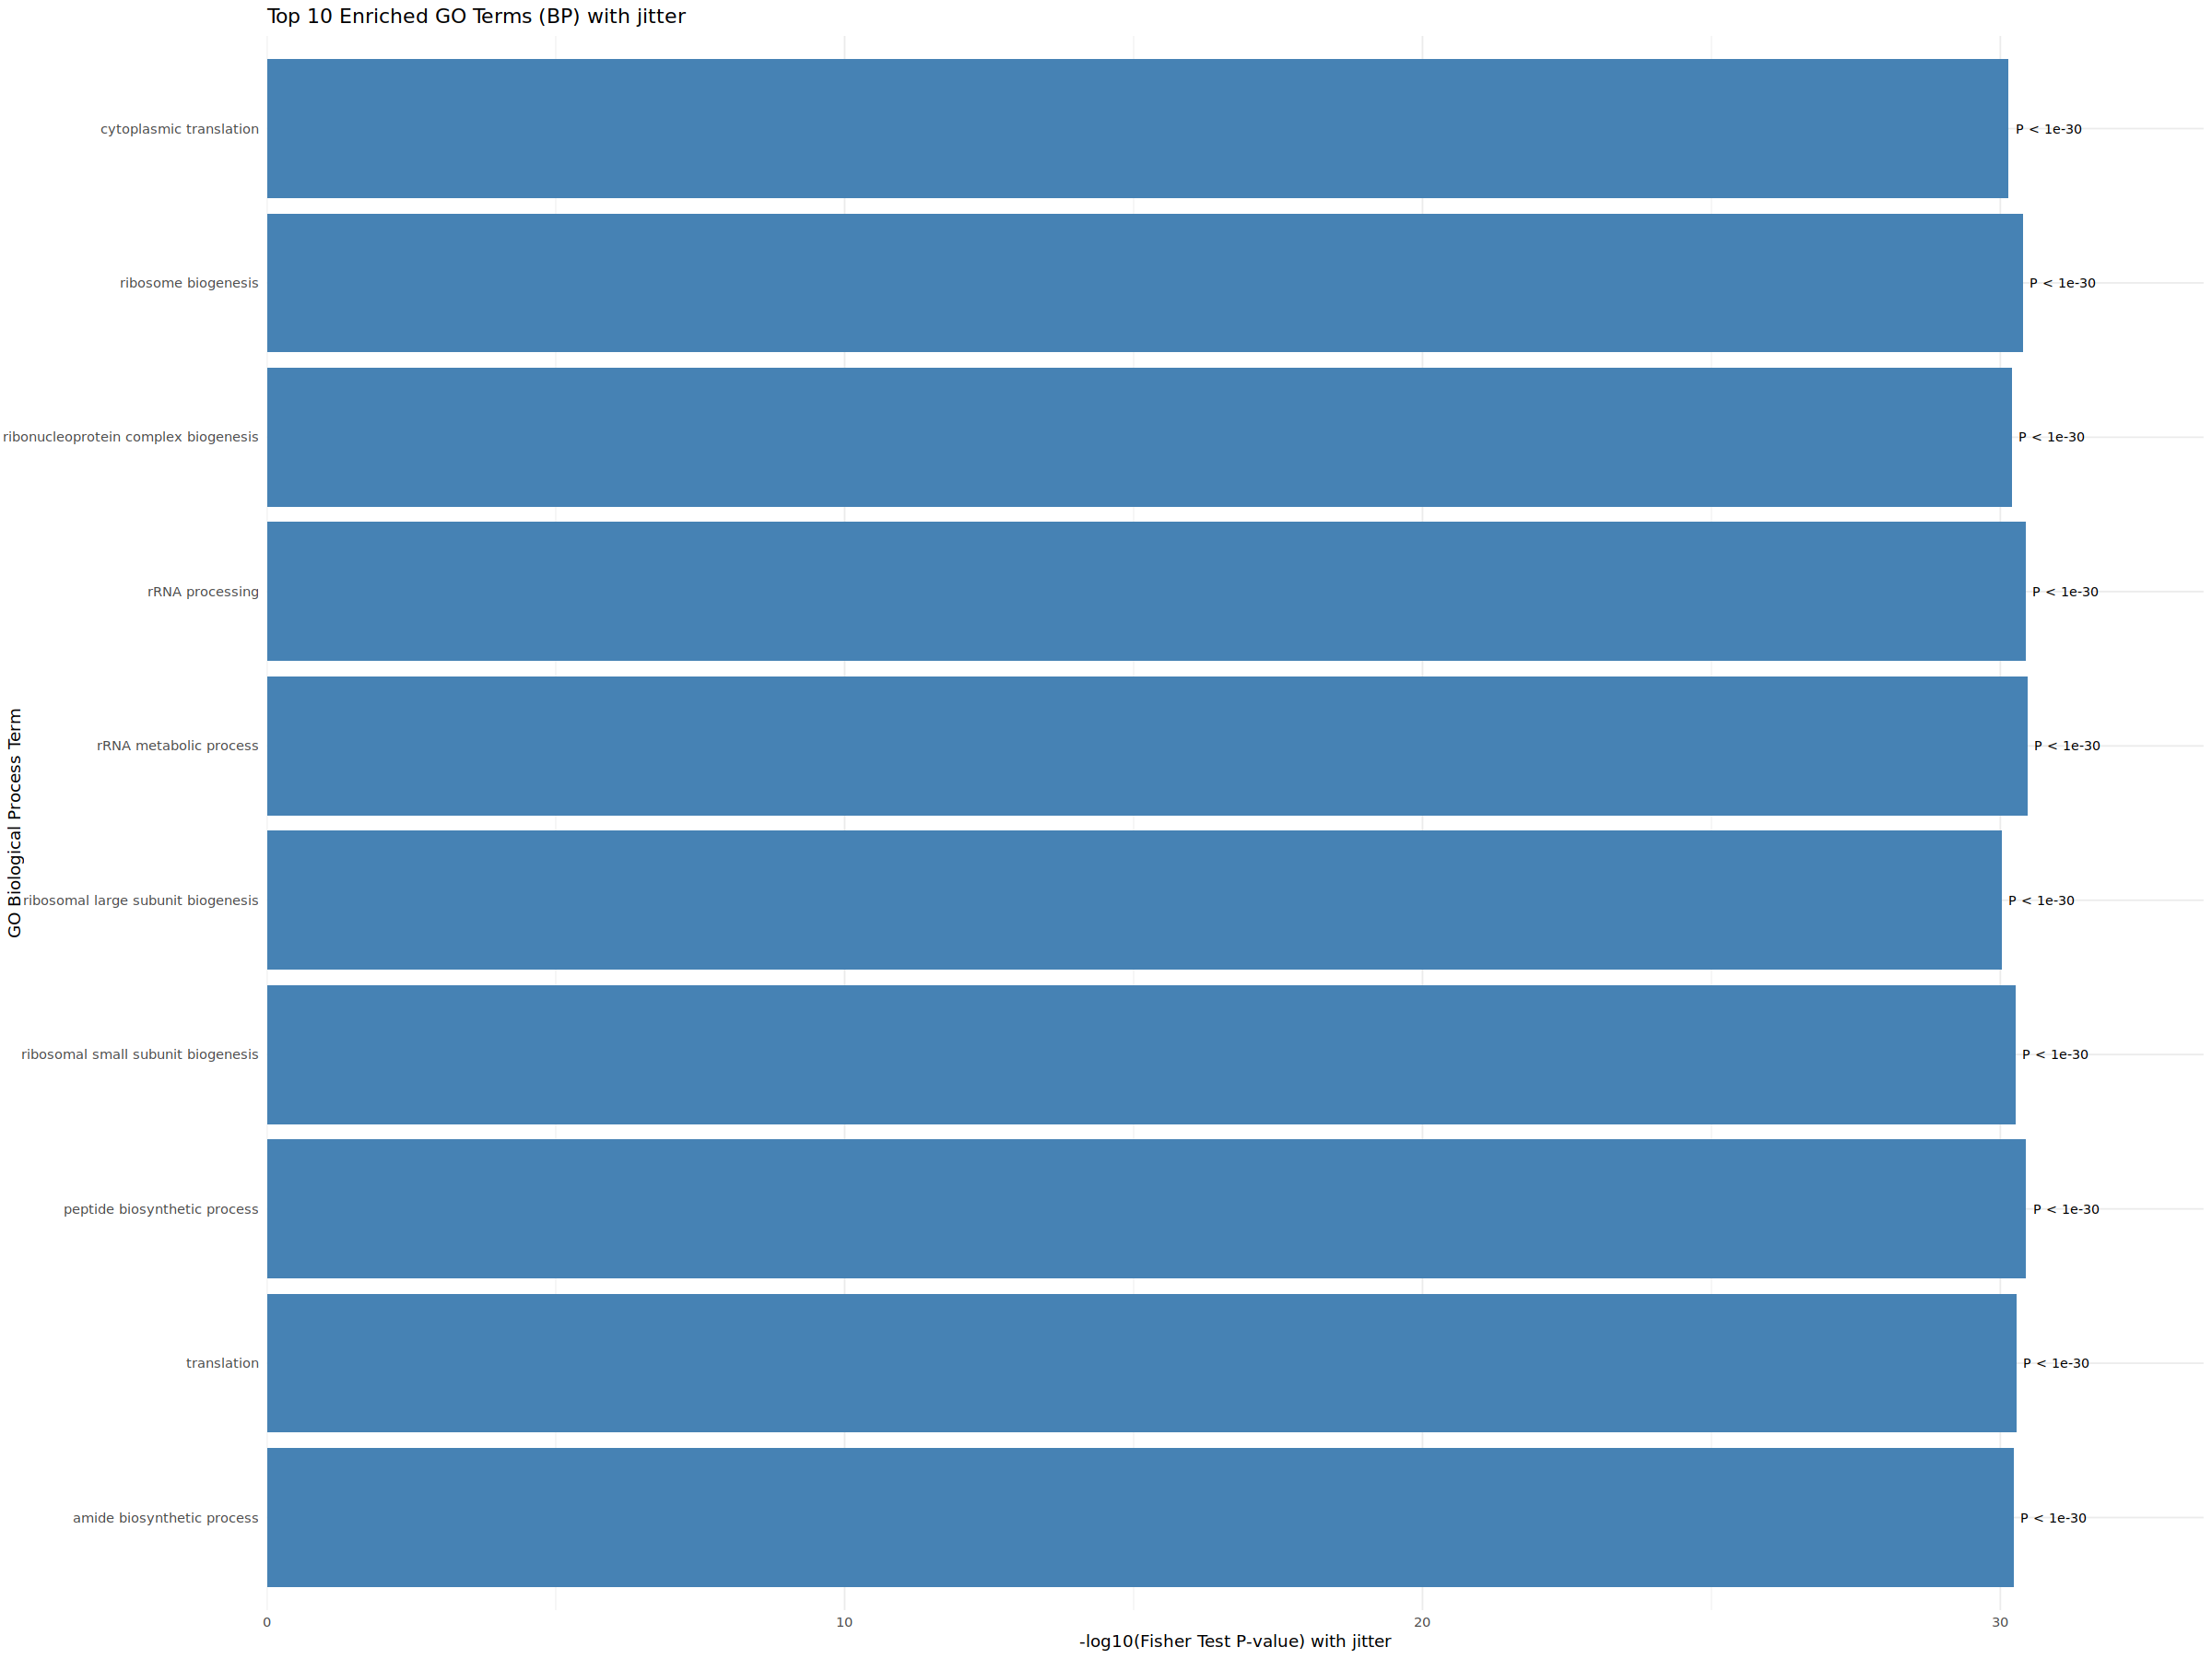

In [91]:
# ================================
# 11b. Plot top GO terms as barplot
# ================================
set.seed(123)
allRes$classicFisherNum <- as.numeric(gsub("<", "", allRes$classicFisher))
allRes$classicFisherNum[is.na(allRes$classicFisherNum)] <- 1e-30
allRes$logP <- -log10(allRes$classicFisherNum)
allRes$logP_jitter <- allRes$logP + runif(nrow(allRes), 0, 0.5)  # tiny noise to separate bars

# Create labels for the bars, replacing super small p-values with "P < 1e-30"
allRes$labelP <- ifelse(allRes$classicFisherNum == 1e-30, "P < 1e-30", signif(allRes$classicFisherNum, 3))
# Make Term a factor for plotting order (descending)
allRes$Term <- factor(allRes$Term, levels = rev(allRes$Term))

ggplot(allRes, aes(x = logP_jitter, y = Term)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  xlab("-log10(Fisher Test P-value) with jitter") +
  ylab("GO Biological Process Term") +
  ggtitle("Top 10 Enriched GO Terms (BP) with jitter") +
  theme_minimal() +
  geom_text(aes(label = labelP), hjust = -0.1, size = 3) +
  scale_x_continuous(expand = expansion(mult = c(0, 0.1)))

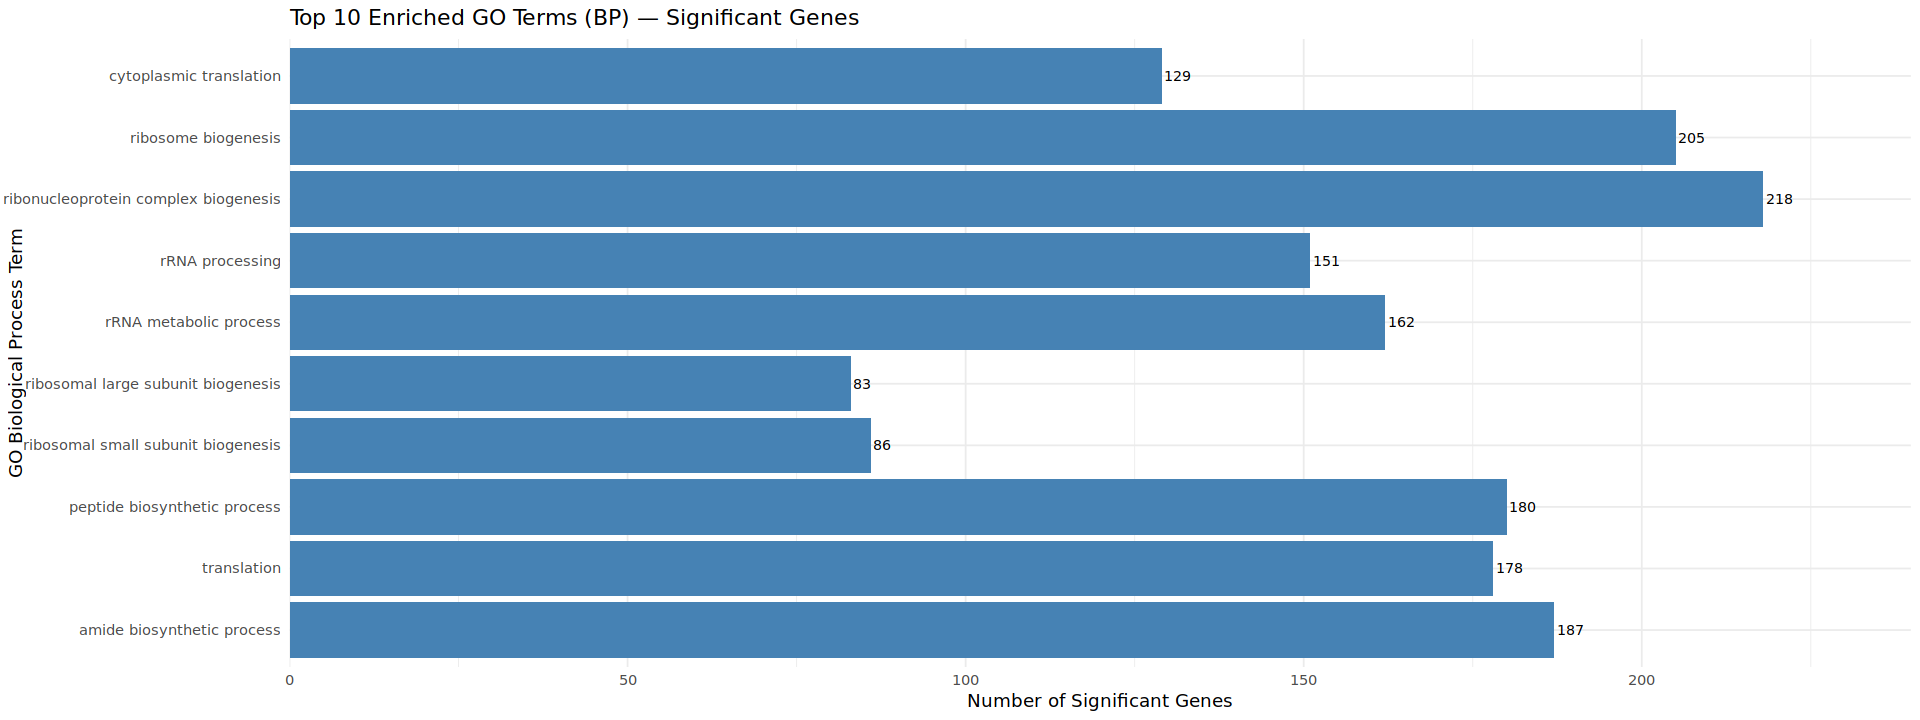

In [87]:
# Plot number of significant genes for the top 10 enriched GO terms
ggplot(allRes, aes(x = Significant, y = Term)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  xlab("Number of Significant Genes") +
  ylab("GO Biological Process Term") +
  ggtitle("Top 10 Enriched GO Terms (BP) — Significant Genes") +
  theme_minimal() +
  geom_text(aes(label = Significant), hjust = -0.1, size = 3) +
  scale_x_continuous(expand = expansion(mult = c(0, 0.1)))

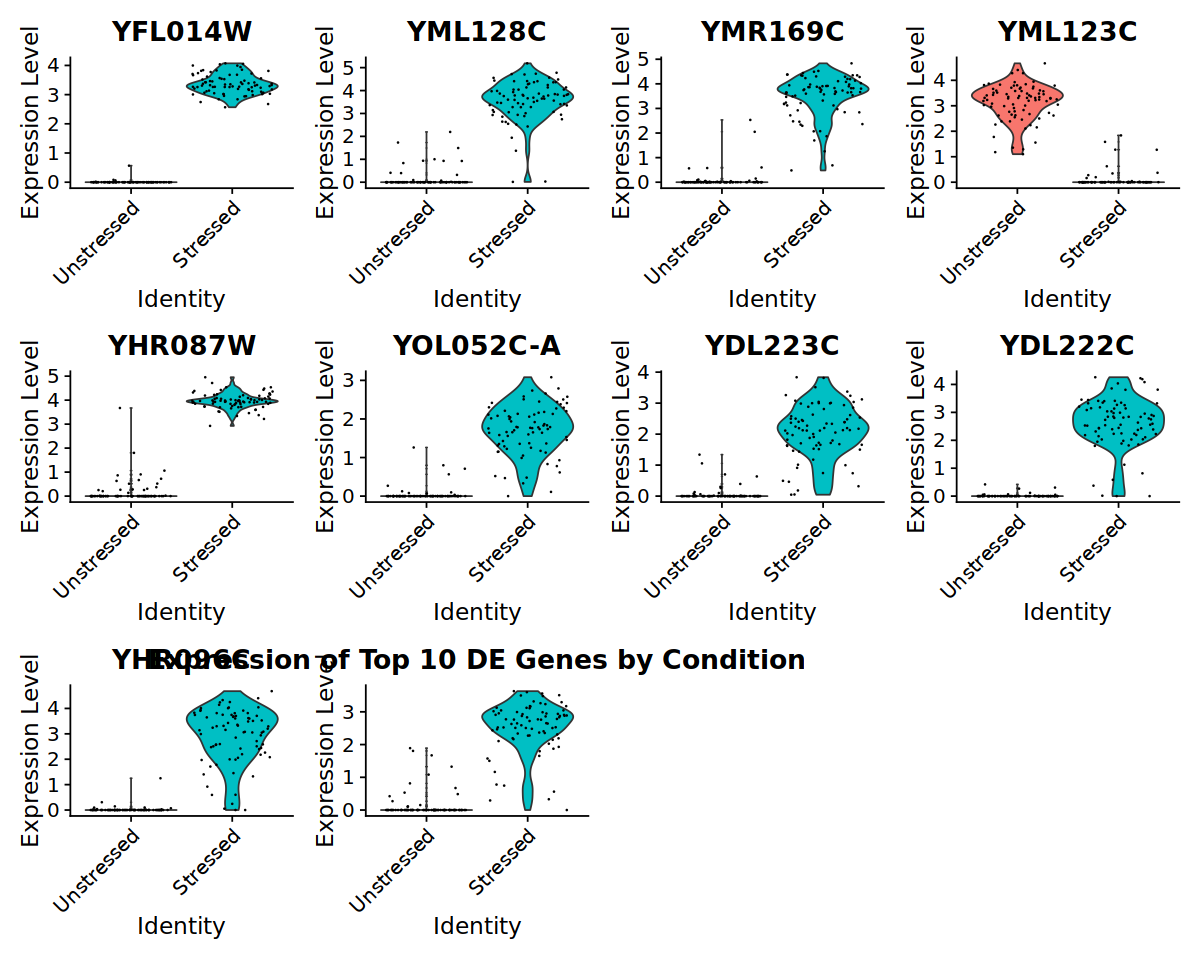

In [97]:
# ================================
# 12. Plot Violin Plots for Top DE Genes
# ================================
options(repr.plot.width = 10, repr.plot.height = 8)

VlnPlot(so, features = top_genes, group.by = "Condition", pt.size = 0.1) + 
  ggtitle("Expression of Top 10 DE Genes by Condition") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

Warning message in DoHeatmap(so, features = top_genes, group.by = "Condition"):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: YOL052C-A”


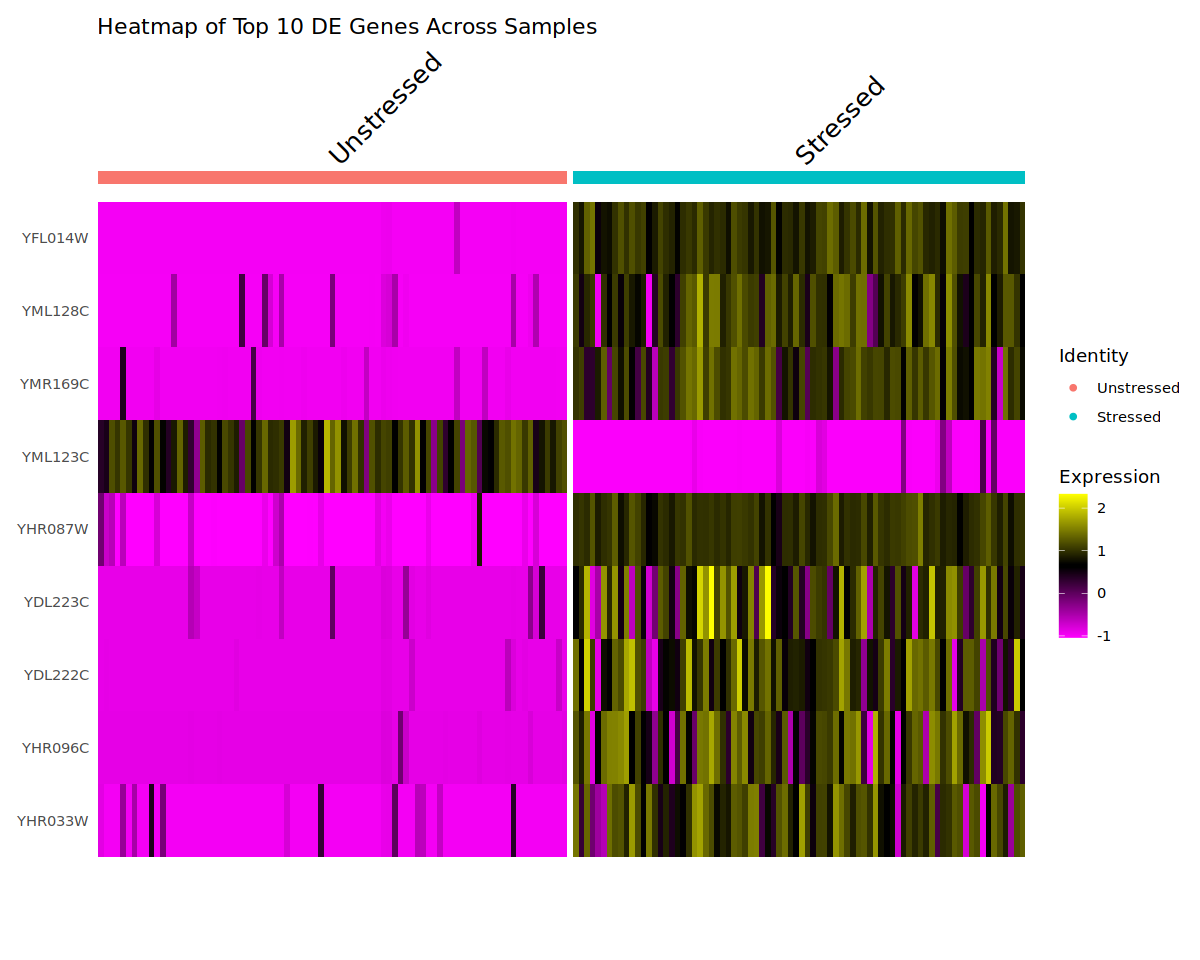

In [98]:
# ================================
# 13. Heatmap of Top DE Genes
# ================================
options(repr.plot.width = 10, repr.plot.height = 8)
DoHeatmap(so, features = top_genes, group.by = "Condition") + 
  ggtitle("Heatmap of Top 10 DE Genes Across Samples")

In [92]:
# ================================
# 14. Save Final Object
# ================================
saveRDS(so, file = "Yeast_SeuratObj.rds")
cat("✅ Full workflow complete!\n")

✅ Full workflow complete!


In [61]:
# This resets the backend and kills all active workers
future::plan(future::sequential)

## Deeper Analysis

In [93]:
# ================================
# 15. Gene Module Scores by Condition
# ================================

# Load gene groups from Supplementary table 8
df <- read_excel("pbio.2004050.s008.xlsx")

# Clean and organize gene groups
gene_group_df <- df %>%
  dplyr::select(UID, `Gene Group`) %>%
  dplyr::filter(!is.na(`Gene Group`)) %>%
  dplyr::mutate(`Gene Group` = trimws(`Gene Group`))  # Remove stray whitespace

# Create named list of gene vectors
gene_lists <- gene_group_df %>%
  group_by(`Gene Group`) %>%
  summarise(gene_list = list(UID), .groups = "drop") %>%
  tibble::deframe()  # Converts to named list like list("RP" = c("YDR417C", ...), "iESR" = c(...))

# Print to check structure
str(gene_lists)

# Load Seurat object
sce <- readRDS("Yeast_SeuratObj.rds")

# Add module scores to Seurat object (sce)
# Loop through each gene group and add module score
for (group_name in names(gene_lists)) {
  sce <- AddModuleScore(sce,
                        features = list(gene_lists[[group_name]]),
                        name = paste0(group_name, "_Score"))
}

List of 4
 $ RP cluster                          : chr [1:148] "YDR417C" "YDR454C" "YEL026W" "YER025W" ...
 $ RiBi (originally called PAC) cluster: chr [1:421] "YAL003W" "YAL025C" "YAL035W" "YAL036C" ...
 $ SGD-annotated RP                    : chr [1:11] "YDL130W" "YDL133C-A" "YDL184C" "YFL034C-A" ...
 $ iESR cluster                        : chr [1:279] "YAL061W" "YBL049W" "YBL064C" "YBL075C" ...


Warning message:
“The following features are not present in the object: YOR277C, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: YOL153C, not searching for symbol synonyms”


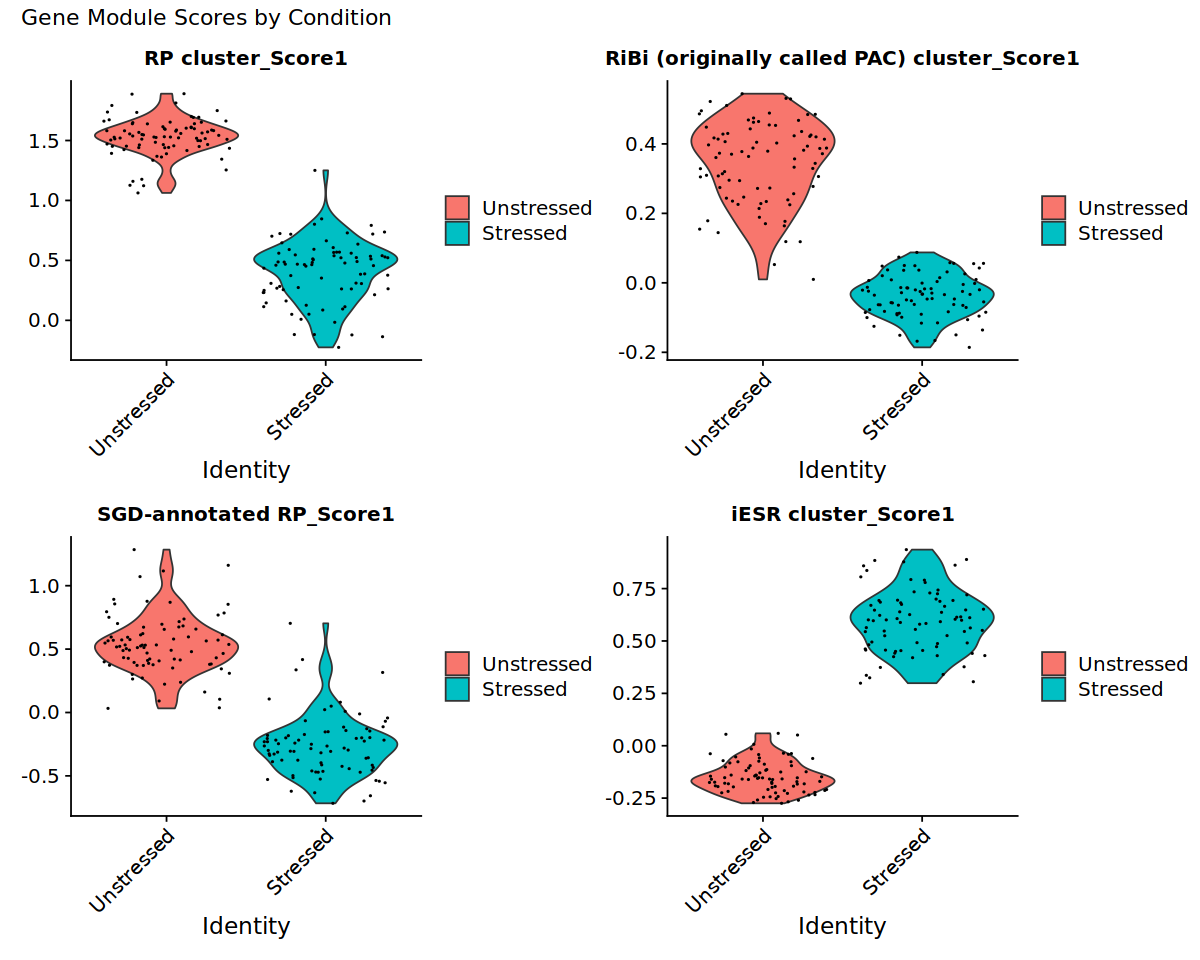

In [105]:
# Plot results
# Grab just the score names (they end in '1')
score_features <- paste0(names(gene_lists), "_Score1")

options(repr.plot.width = 10, repr.plot.height = 8)

# Violin plot by condition
plots <- lapply(score_features, function(f) {
  VlnPlot(sce, features = f, group.by = "Condition") +
    ggtitle(f) +
    theme(
      plot.title = element_text(hjust = 0.5, size = 12),
      axis.text.x = element_text(angle = 45, hjust = 1)
    )
})

wrap_plots(plots, ncol = 2) + plot_annotation(title = "Gene Module Scores by Condition")

## Recreating Fig 1(b)

In [127]:
# ================================
# 16. Recreating Fig. 1(b)
# ================================

plot_module_score_scatter <- function(seurat_obj, gene_lists, group1, group2 = NULL, title = NULL) {
  # Make syntactically valid gene group names
  clean_names <- make.names(names(gene_lists))
  names(gene_lists) <- clean_names
  
  # Add module scores if not already present
  for (i in seq_along(gene_lists)) {
    score_name <- paste0(names(gene_lists)[i], "_Score1")
    if (!(score_name %in% colnames(seurat_obj@meta.data))) {
      seurat_obj <- AddModuleScore(seurat_obj,
                                   features = list(gene_lists[[i]]),
                                   name = paste0(names(gene_lists)[i], "_Score"))
    }
  }

  # Allow input by name or index
  if (is.numeric(group1)) group1 <- names(gene_lists)[group1]
  if (is.null(group2)) {
    if (length(gene_lists) < 2) stop("At least two gene groups required.")
    group2 <- names(gene_lists)[2]
  } else if (is.numeric(group2)) group2 <- names(gene_lists)[group2]
  
  # Score feature names
  f1 <- paste0(make.names(group1), "_Score1")
  f2 <- paste0(make.names(group2), "_Score1")
  
  if (all(c(f1, f2) %in% colnames(seurat_obj@meta.data))) {
    p <- FeatureScatter(seurat_obj, feature1 = f1, feature2 = f2, group.by = "Condition") +
      ggtitle(title %||% paste("Score Comparison:", group1, "vs", group2))
    return(p)
  } else {
    warning("One or both features not found in Seurat object metadata.")
    cat("Available features:\n")
    print(colnames(seurat_obj@meta.data))
    cat("Requested features:\n")
    print(c(f1, f2))
  }
}

Warning message:
“The following features are not present in the object: YOR277C, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: YOL153C, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: YOR277C, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: YOL153C, not searching for symbol synonyms”


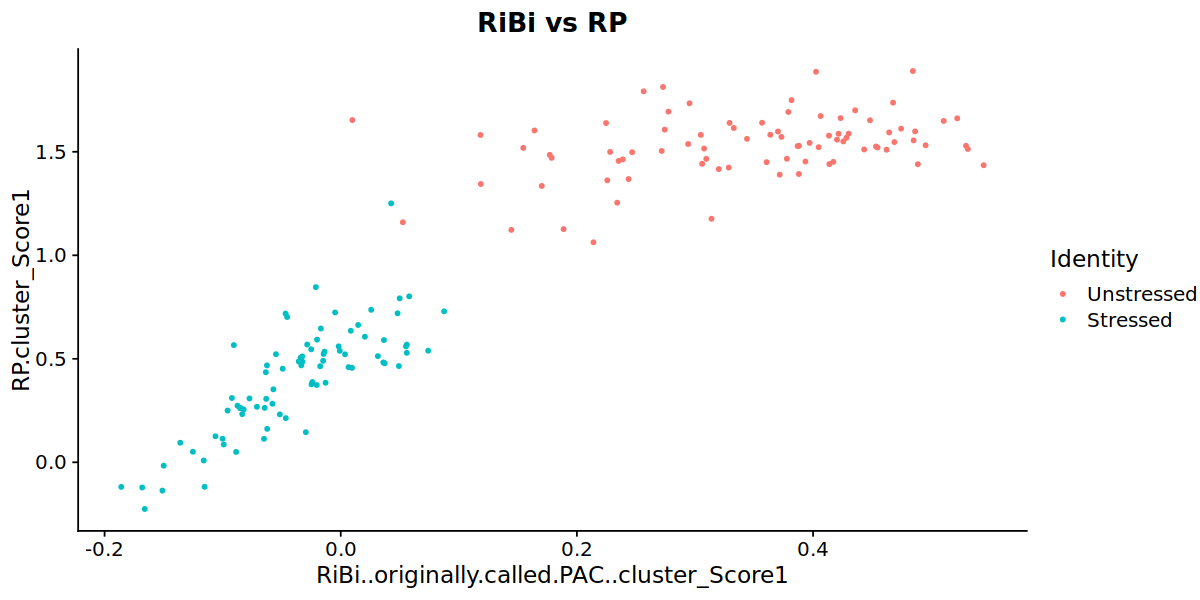

Warning message:
“The following features are not present in the object: YOR277C, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: YOL153C, not searching for symbol synonyms”


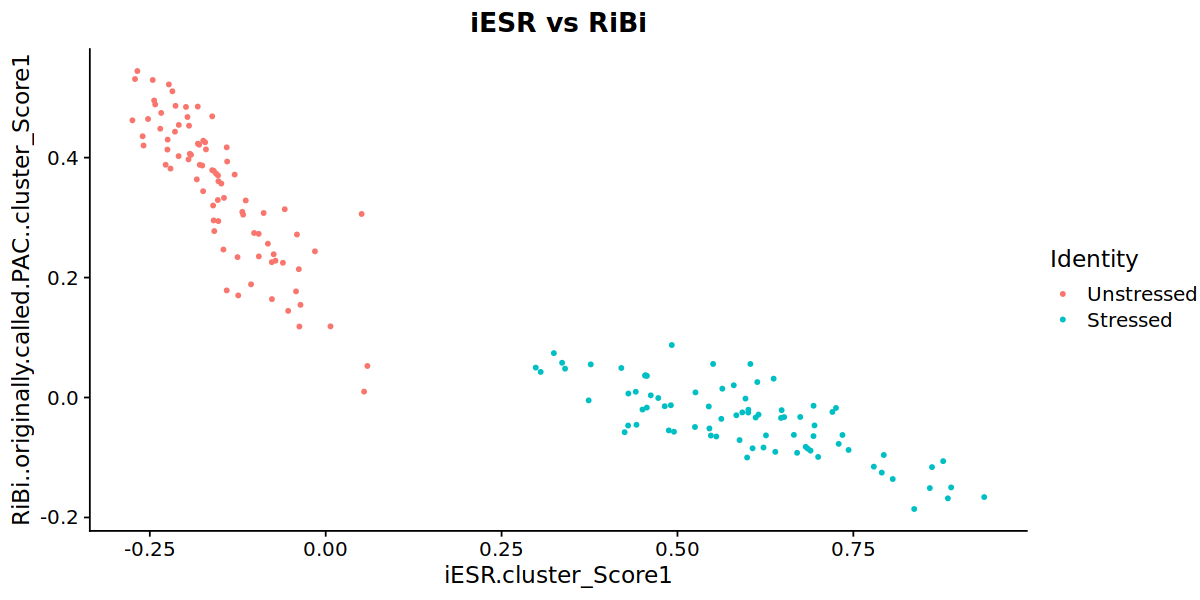

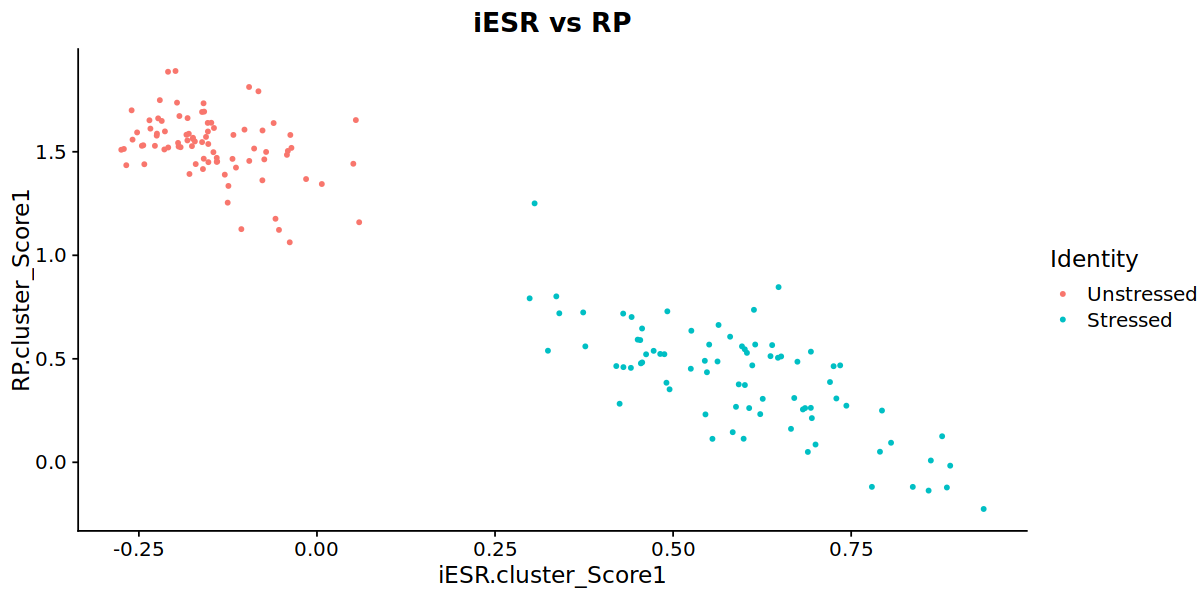

In [137]:
options(repr.plot.width = 10, repr.plot.height = 5)
# sce = Seurat object
plot_module_score_scatter(sce, gene_lists, 2, 1, "RiBi vs RP")
plot_module_score_scatter(sce, gene_lists, 4, 2, "iESR vs RiBi")
plot_module_score_scatter(sce, gene_lists, 4, 1, "iESR vs RP")

## Recreating Fig 1(a)

In [60]:
# ================================
# 17. Recreating Fig. 1(a)
# ================================

# View number of genes in each module
for (group_name in names(gene_lists)) {
  genes_present <- intersect(rownames(sce), gene_lists[[group_name]])
  cat(group_name, ":", length(genes_present), "genes present\n")
}

RP cluster : 148 genes present
RiBi (originally called PAC) cluster : 420 genes present
SGD-annotated RP : 11 genes present
iESR cluster : 278 genes present


In [130]:
all_genes <- unique(unlist(gene_lists))
genes_present <- intersect(rownames(sce), all_genes)

# Reverse map: gene -> gene group
gene_to_group <- rep(NA, length(genes_present))
names(gene_to_group) <- genes_present

for (group_name in names(gene_lists)) {
  genes_in_group <- intersect(genes_present, gene_lists[[group_name]])
  gene_to_group[genes_in_group] <- group_name
}

counts <- GetAssayData(sce, slot = "counts")
mat <- counts[genes_present, ]

log_mat <- log2(as.matrix(mat) + 1)
mean_centered <- t(scale(t(log_mat), center = TRUE, scale = FALSE))

# Order genes by their assigned gene group (factors)
gene_group_factor <- factor(gene_to_group, levels = names(gene_lists))
gene_order <- order(gene_group_factor)

mean_centered_ordered <- mean_centered[gene_order, ]

# Cluster cells by module scores as before
score_features <- grep("_Score1$", colnames(sce@meta.data), value = TRUE)
module_scores <- sce@meta.data[, score_features]

dist_cells <- dist(module_scores)
hc_cells <- hclust(dist_cells, method = "ward.D2")
ordered_cells <- rownames(module_scores)[hc_cells$order]

# Reorder columns by clustered cells
mean_centered_ordered <- mean_centered_ordered[, ordered_cells]


Warning message in brewer.pal(n = length(unique(condition_vector)), name = "Accent"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


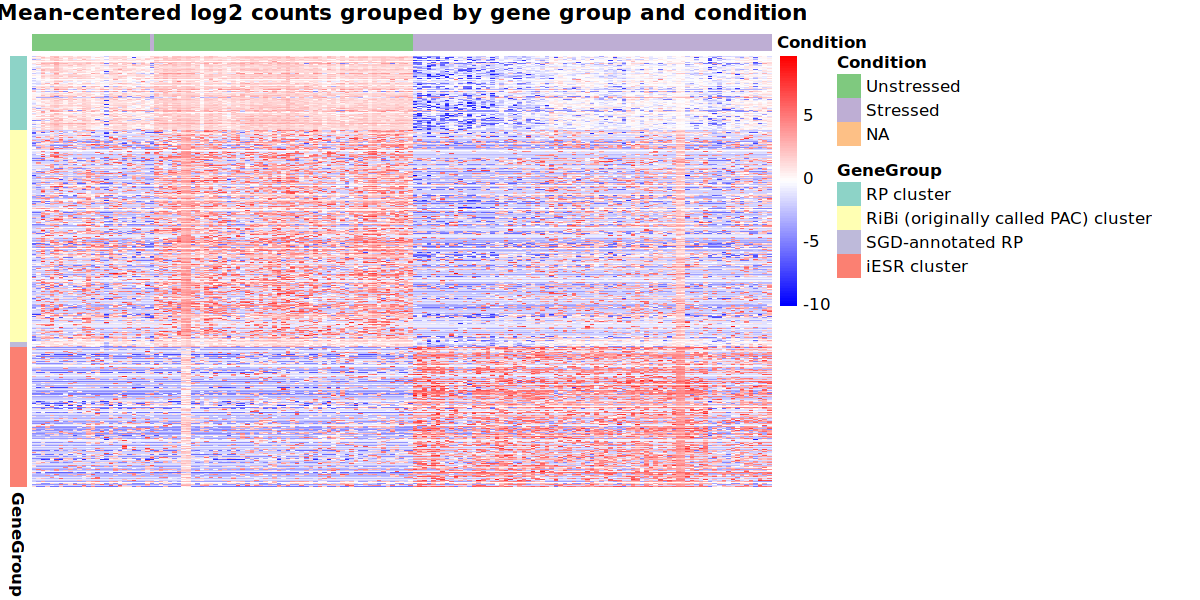

In [143]:
# Prepare row annotation (gene groups)
annotation_row <- data.frame(GeneGroup = gene_to_group[rownames(mean_centered_ordered)])
rownames(annotation_row) <- rownames(mean_centered_ordered)

# Color palette for gene groups
group_colors <- brewer.pal(n = length(unique(annotation_row$GeneGroup)), name = "Set3")
names(group_colors) <- unique(annotation_row$GeneGroup)
ann_colors <- list(GeneGroup = group_colors)

# Prepare column annotation (conditions)
# Extract condition vector from Seurat metadata
condition_vector <- so@meta.data$Condition

# Make sure names of condition_vector match the columns of matrix exactly
names(condition_vector) <- rownames(so@meta.data)
condition_vector <- condition_vector[colnames(mean_centered_ordered)]

annotation_col <- data.frame(Condition = condition_vector)
rownames(annotation_col) <- colnames(mean_centered_ordered)

# Color palette for conditions
condition_colors <- brewer.pal(n = length(unique(condition_vector)), name = "Accent")
names(condition_colors) <- unique(condition_vector)
ann_colors$Condition <- condition_colors

# Plot heatmap with both row and column annotations
pheatmap(mean_centered_ordered,
         cluster_rows = FALSE,       # Keep gene order fixed
         cluster_cols = FALSE,       # Keep column order fixed
         annotation_row = annotation_row,
         annotation_col = annotation_col,
         annotation_colors = ann_colors,
         show_rownames = FALSE,
         show_colnames = FALSE,
         color = colorRampPalette(c("blue", "white", "red"))(100),
         main = "Mean-centered log2 counts grouped by gene group and condition")


## Recreating Fig 1(c)

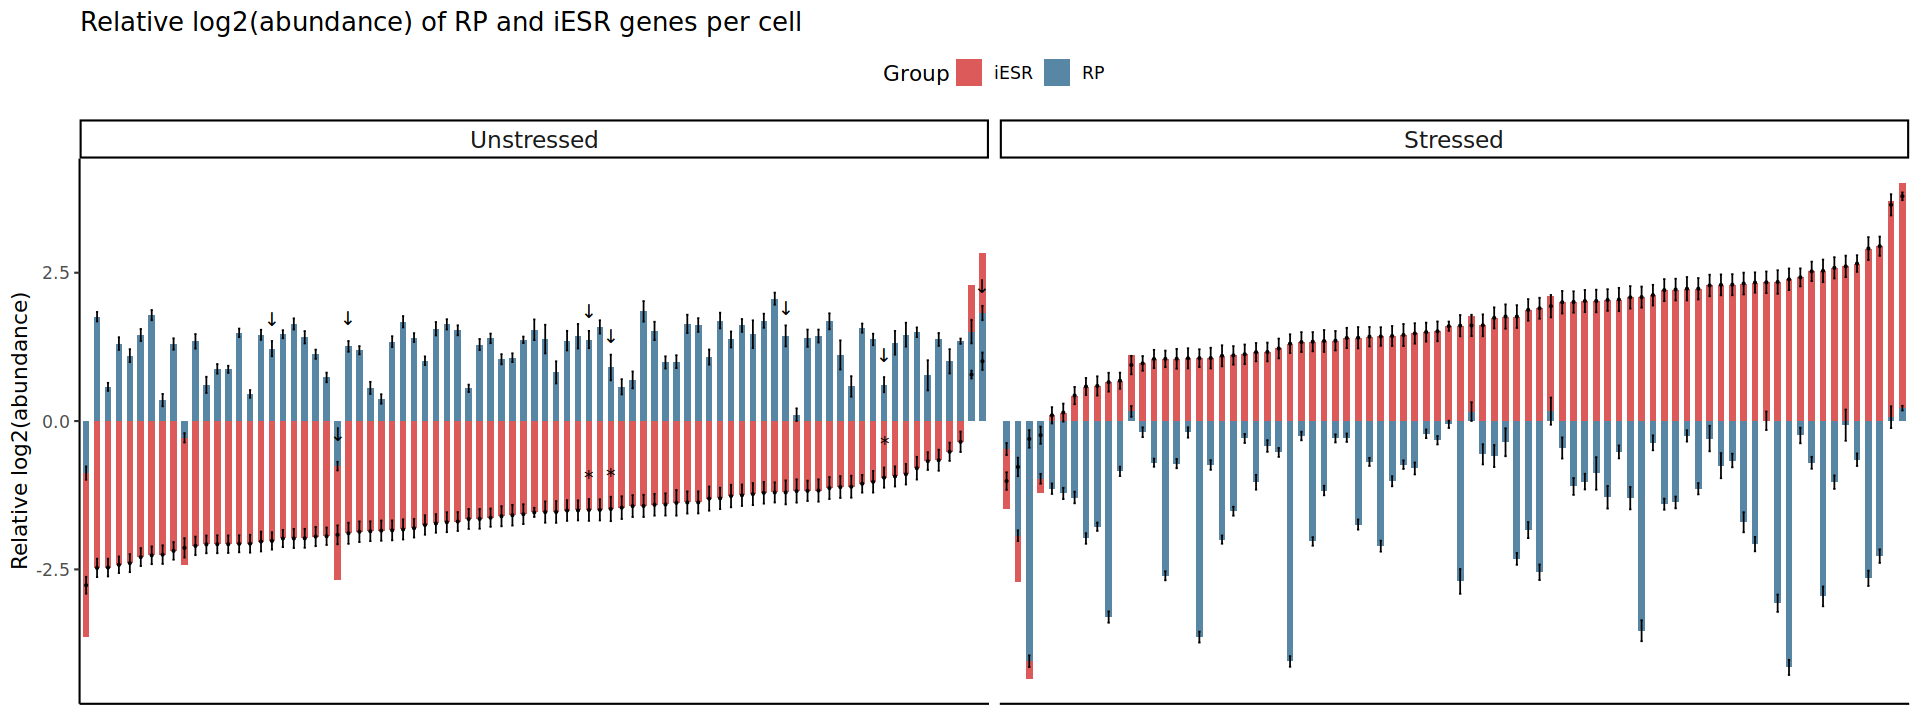

In [39]:
# ================================
# 18. Recreating Fig. 1(c)
# ================================

# Extract genes
rp_genes <- intersect(rownames(sce), gene_lists[["RP.cluster"]])
iesr_genes <- intersect(rownames(sce), gene_lists[["iESR.cluster"]])

# Get mean-centered log2 counts
counts <- GetAssayData(sce, slot = "counts")
log_counts <- log2(as.matrix(counts) + 1)
mean_centered <- t(scale(t(log_counts), center = TRUE, scale = FALSE))

# Subset and summarize
expr_stats <- data.frame(Cell = colnames(mean_centered))

expr_stats$mean_iESR <- colMeans(mean_centered[iesr_genes, , drop = FALSE], na.rm = TRUE)
expr_stats$sem_iESR <- apply(mean_centered[iesr_genes, , drop = FALSE], 2, function(x) sd(x)/sqrt(length(x)))

expr_stats$mean_RP <- colMeans(mean_centered[rp_genes, , drop = FALSE], na.rm = TRUE)
expr_stats$sem_RP <- apply(mean_centered[rp_genes, , drop = FALSE], 2, function(x) sd(x)/sqrt(length(x)))

# Add condition from metadata
expr_stats$Condition <- sce@meta.data$Condition[match(expr_stats$Cell, rownames(sce@meta.data))]

# Order cells by iESR median within each condition
expr_stats <- expr_stats %>%
  arrange(Condition, mean_iESR) %>%
  mutate(Cell = factor(Cell, levels = Cell))  # preserve order

# Reshape to long format for ggplot
long_df <- expr_stats %>%
  pivot_longer(cols = c("mean_iESR", "mean_RP"), names_to = "Group", values_to = "Mean") %>%
  mutate(SEM = ifelse(Group == "mean_iESR", expr_stats$sem_iESR, expr_stats$sem_RP),
         Group = ifelse(Group == "mean_iESR", "iESR", "RP"))

# Simulate arrows and asterisks for some unstressed cells (using FDR)
set.seed(42)
unstressed_cells <- expr_stats$Cell[expr_stats$Condition == "Unstressed"]
low_rp_cells <- sample(unstressed_cells, 8)
high_iesr_cells <- sample(low_rp_cells, 3)

# Plot
p <- ggplot(long_df, aes(x = Cell, y = Mean, fill = Group)) +
  geom_bar(stat = "identity", width = 0.6) +  # Removed outline (no color=black)
  geom_errorbar(aes(ymin = Mean - SEM, ymax = Mean + SEM), width = 0.2) +
  geom_point(data = expr_stats, aes(x = Cell, y = mean_iESR), color = "black", size = 0.5, inherit.aes = FALSE) +
  facet_wrap(~Condition, scales = "free_x", nrow = 1) +
  scale_fill_manual(values = c("RP" = "#5886A5", "iESR" = "#DC5A5A")) +
  theme_classic(base_size = 13) +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    strip.text = element_text(size = 14),
    legend.position = "top"
  ) +
  labs(
    title = "Relative log2(abundance) of RP and iESR genes per cell",
    x = NULL,
    y = "Relative log2(abundance)"
  )

# Add arrows and asterisks
p <- p + geom_text(data = expr_stats %>% filter(Cell %in% low_rp_cells),
                   aes(x = Cell, y = mean_RP + sem_RP + 0.4),
                   label = "↓", color = "black", inherit.aes = FALSE, size = 4)

p <- p + geom_text(data = expr_stats %>% filter(Cell %in% high_iesr_cells),
                   aes(x = Cell, y = mean_iESR + sem_iESR + 0.4),
                   label = "*", color = "black", inherit.aes = FALSE, size = 4)

print(p)